In [82]:
import os
# 提出時は足す
# !pip install pycaret -full
# 提出時は消す
os.chdir('C:\\Users\\Takanori\\Desktop\\Kaggle\\TPS2204\\input')

# Introduction
Hey, thanks for viewing my Kernel!

If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)

EDA was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-eda-fe-baseline)</br>
Pseudo Labeling was done in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-fe-pseudo-labels-baseline)</br>
Prediction without NN is in this [notebook](https://www.kaggle.com/code/hasanbasriakcay/tpsapr22-optuna-lgbm-blend)

In [83]:
import pandas as pd
import numpy as np
import warnings 

warnings.simplefilter("ignore")
# indexを指定しないと、PyCaretの予測結果がめちゃくちゃになる?
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
train_labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

display(train.head())
display(test.head())
display(train_labels.head())
display(sub.head())

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [84]:
sensors = [col for col in train.columns if 'sensor_' in col]
train_pivoted0 = train.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
test_pivoted0 = test.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
display(train_pivoted0.head())

sensor_00                                                    \
step                    0         1         2         3         4         5    
sequence subject                                                               
0        47      -0.196291 -0.447450  0.326893  0.523184  0.272025 -1.073416   
1        66      -6.657651  1.633694  1.863215 -2.846213  0.593509  2.469861   
2        66      -1.741886  3.402628 -0.632148  0.208655 -0.800618 -2.274343   
3        542      0.264297 -1.808346  0.078825  1.037094 -0.189335 -1.302937   
4        437      0.567233 -0.823802  1.476816 -1.710201 -0.408810  0.556414   

                                                          ... sensor_12  \
step                    6         7         8         9   ...        50   
sequence subject                                          ...             
0        47       0.350850 -0.304482 -0.216383  0.303709  ... -1.670077   
1        66      -1.202473 -0.829212  1.091190 -0.334621  ... -0.338022   
2        66       2.009274 -0.563369 -0.050232  0.800618  ... -0.172634   
3        542      1.078825  2.257342 -2.283617 -2.759660  ...  0.145354   
4        437      0.853168 -0.406491 -0.009274 -0.021638  ...  0.001705   

                                                                              \
step                    51        52        53        54        55        56   
sequence subject                                                               
0        47      -5.306479  3.621057  4.965047 -3.615090  0.791134  5.887042   
1        66       0.234868  0.030691  0.037511 -0.120205  0.056692  0.062234   
2        66       0.091645 -0.028986 -0.202472  0.332481 -0.013214  0.245524   
3        542     -0.045610 -0.098039 -0.049446  0.055840 -0.022165  0.054135   
4        437     -0.050725 -0.025149  0.106138 -0.098465 -0.040068  0.135976   

                                                  
step                    57         58         59  
sequence subject                                  
0        47      -7.211424 -26.738704 -50.658994  
1        66      -0.013640   0.098039  -0.115090  
2        66      -0.091219  -0.306905   0.046036  
3        542     -0.185422   0.311168  -0.166240  
4        437      0.121910  -0.059676  -0.087809  

[5 rows x 780 columns]

# Feature Engineering

In [85]:
from scipy.fft import rfft
column_name = ['sensor_00_rfft' + str(i) for i in range(31)]
pd.DataFrame(np.abs(rfft(train_pivoted0['sensor_00'])), columns=column_name)

,sensor_00_rfft0,sensor_00_rfft1,sensor_00_rfft2,sensor_00_rfft3,sensor_00_rfft4,sensor_00_rfft5,sensor_00_rfft6,sensor_00_rfft7,sensor_00_rfft8,sensor_00_rfft9,...,sensor_00_rfft21,sensor_00_rfft22,sensor_00_rfft23,sensor_00_rfft24,sensor_00_rfft25,sensor_00_rfft26,sensor_00_rfft27,sensor_00_rfft28,sensor_00_rfft29,sensor_00_rfft30
0,2.504637,2.595997,2.948970,2.906888,2.510662,3.610021,6.967675,5.406874,5.151776,5.505501,...,11.014318,11.750337,17.474863,12.386601,20.420512,17.011775,16.043118,15.018459,11.104754,0.611283
1,4.157651,4.200879,4.329791,4.915330,4.735261,4.744518,6.233446,7.827523,2.507145,7.286906,...,13.864478,16.321710,11.801698,2.673012,7.130912,12.673452,9.965262,6.051014,10.764455,5.463679
2,0.092736,1.069003,0.969934,2.543404,1.580156,0.734563,5.417217,5.094902,5.865716,5.179019,...,6.225477,16.486949,9.952388,17.729356,5.145735,5.374435,14.642103,9.808540,6.582893,5.874807
3,1.792117,2.226034,2.929472,1.060576,2.625198,4.091992,3.418150,2.407677,6.570212,7.279072,...,17.170347,12.297775,13.847360,9.082162,8.400443,19.515401,9.398150,9.387191,2.476308,12.459815
4,3.547913,3.386796,2.926308,4.566577,5.807639,0.868438,14.607558,5.334614,6.761871,22.263778,...,14.970596,12.878400,10.194339,12.077422,3.838857,13.439833,18.137059,15.406782,22.872590,1.843122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,6.046368,5.722454,5.103660,3.089471,2.429315,4.292279,9.798682,7.647297,8.446059,11.105860,...,11.233583,23.231182,23.970185,12.969884,10.125960,14.416672,12.091264,17.388369,12.319864,18.123648
25964,1.030912,1.039292,0.609536,1.498650,0.562541,0.612849,3.265756,1.693138,4.232479,4.702865,...,11.948758,10.646301,8.578913,14.362255,6.788820,9.463802,18.420476,9.007468,15.593278,4.398764
25965,0.387944,2.065679,0.834849,1.400982,4.371744,7.031081,1.202475,1.857641,0.709506,5.252155,...,7.990889,20.660948,8.261659,12.600741,10.893485,3.551999,3.529349,5.201556,14.945819,1.437403
25966,2.425039,1.056059,1.240733,1.840394,1.069282,3.947742,4.737424,6.108543,3.956349,5.433704,...,3.820473,19.778656,12.033654,3.576206,7.375706,7.139156,1.364939,0.711445,5.882148,6.293663


In [86]:
# https://www.kaggle.com/code/ambrosm/tpsapr22-best-model-without-nn
# Feature engineering

def engineer(df):
    import scipy.stats
    new_df = pd.DataFrame([], index=df.index)
    for sensor in sensors:
        # ピボットした後のdfは、columnsを指定すると、いくつかの行をまとめて取ってこれる
        new_df[sensor + '_mean'] = df[sensor].mean(axis=1)
        new_df[sensor + '_std'] = df[sensor].std(axis=1)
        new_df[sensor + '_iqr'] = scipy.stats.iqr(df[sensor], axis=1)
        new_df[sensor + '_kurtosis'] = scipy.stats.kurtosis(df[sensor], axis=1)

        # フーリエ変換
        columns_list = [sensor + '_rfft' + str(i) for i in range(31)]
        rfftdf = pd.DataFrame(np.abs(rfft(df[sensor])), columns=columns_list)
        for column_name in columns_list:
            new_df[column_name] = rfftdf[column_name].values
    new_df['sensor_02_up'] = (df.sensor_02.diff(axis=1) > 0).sum(axis=1)
    new_df['sensor_02_down'] = (df.sensor_02.diff(axis=1) < 0).sum(axis=1)
    new_df['sensor_02_upsum'] = df.sensor_02.diff(axis=1).clip(0, None).sum(axis=1)
    new_df['sensor_02_downsum'] = df.sensor_02.diff(axis=1) .clip(None, 0).sum(axis=1)
    new_df['sensor_02_upmax'] = df.sensor_02.diff(axis=1).max(axis=1)
    new_df['sensor_02_downmax'] = df.sensor_02.diff(axis=1).min(axis=1)
    new_df['sensor_02_upmean'] = np.nan_to_num(new_df['sensor_02_upsum'] / new_df['sensor_02_up'], posinf=32)
    new_df['sensor_02_downmean'] = np.nan_to_num(new_df['sensor_02_downsum'] / new_df['sensor_02_down'], neginf=-32)
    return new_df

# sequence別に統計量を計算する
train_pivoted = engineer(train_pivoted0)
test_pivoted = engineer(test_pivoted0)

train_shuffled = train_pivoted.sample(frac=1.0, random_state=1)  # ランダムに並び替え・・・なんのために?
labels_shuffled = train_labels.reindex(train_shuffled.index.get_level_values('sequence'))
labels_shuffled = labels_shuffled[['state']].merge(train[['sequence', 'subject']].groupby('sequence').min(),
                                                   how='left', on='sequence')
labels_shuffled = labels_shuffled.merge(labels_shuffled.groupby('subject').size().rename('sequence_count'),
                                        how='left', on='subject')
train_shuffled['sequence_count_of_subject'] = labels_shuffled['sequence_count'].values

sequence_count = test_pivoted.index.to_frame(index=False).groupby('subject').size().rename('sequence_count_of_subject')
test_pivoted = test_pivoted.merge(sequence_count, how='left', on='subject')

selected_columns = train_shuffled.columns
print(len(selected_columns))
#train_shuffled.columns

In [ ]:
train_shuffled.head()

,,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_00_rfft0,sensor_00_rfft1,sensor_00_rfft2,sensor_00_rfft3,sensor_00_rfft4,sensor_00_rfft5,...,sensor_12_rfft30,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject
sequence,subject,,,,,,,,,,,,,,,,,,,,,
10611,242,0.001365,0.457624,0.511785,-0.263845,0.081917,0.092124,0.315373,0.151339,0.218885,0.625943,...,3.984228,10,9,1.841667,-1.841667,0.301667,-0.303333,0.184167,-0.204630,31
14656,536,-0.010484,0.949162,0.977589,2.037479,0.629057,0.845340,1.029175,0.749474,0.366593,1.026304,...,7.668798,12,11,1.826153,-1.826153,0.230000,-0.333333,0.152179,-0.166014,51
19119,245,-0.013730,1.369316,1.373068,0.982639,0.823802,0.793589,1.656657,1.875902,1.093639,4.389030,...,82.180307,8,12,1.333847,-2.000514,0.254607,-0.303801,0.166731,-0.166709,46
8143,547,0.013357,1.466844,1.906298,-0.329048,0.801391,5.907966,4.561377,5.991720,4.912017,7.757203,...,1.390878,12,18,3.526520,-3.216998,0.951628,-0.311667,0.293877,-0.178722,51
19368,120,-0.129019,1.637407,1.941267,4.630269,7.741113,7.656127,7.144146,6.209401,8.338745,8.844321,...,115.416880,12,18,3.472306,-4.102306,0.999486,-1.239486,0.289359,-0.227906,28


* PyCaretを使ってみる
* https://pycaret.gitbook.io/docs/

In [ ]:
import pycaret
from pycaret.classification import *
from pycaret.classification import setup, compare_models, blend_models, finalize_model, predict_model, plot_model

In [ ]:
# 予測対象であるstateをくっつける
train_df_label = pd.merge(train_shuffled, train_labels, how='left', on='sequence')

In [ ]:
train_df_label.tail()

,sequence,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_kurtosis,sensor_02_mean,...,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject,state
25963,10955,0.068921,1.936319,1.423107,3.844153,0.060364,1.603716,1.257090,7.010847,-0.122675,...,5,9,0.902029,-1.902029,0.235362,-0.666667,0.180406,-0.211337,77,1
25964,17289,-0.007986,1.320915,2.068199,-0.153580,-0.021359,1.440422,1.933561,-0.468555,0.616744,...,4,4,0.665639,-0.665639,0.251279,-0.251279,0.166410,-0.166410,31,0
25965,5192,-0.018148,0.519007,0.534196,1.984689,-0.031513,0.420650,0.571954,-0.213731,0.340828,...,5,8,0.999486,-1.333333,0.333847,-0.284561,0.199897,-0.166667,97,1
25966,12172,-0.005358,0.724569,0.746909,0.165472,-0.027679,0.729696,0.933561,-0.366121,-0.095579,...,10,11,1.582820,-2.582306,0.250385,-0.666153,0.158282,-0.234755,79,1
25967,235,-0.003014,0.790997,0.803709,0.650815,0.026383,0.558247,0.799107,-0.127523,-1.127264,...,7,6,2.225000,-1.558333,1.000000,-0.666667,0.317857,-0.259722,37,0


In [ ]:
train_df_label.dtypes

sequence                       int64
sensor_00_mean               float64
sensor_00_std                float64
sensor_00_iqr                float64
sensor_00_kurtosis           float64
                              ...   
sensor_02_downmax            float64
sensor_02_upmean             float64
sensor_02_downmean           float64
sequence_count_of_subject      int64
state                          int64
Length: 63, dtype: object

In [ ]:
feature_selection_threshold_ = 0.3  # 0.1で25項目, 0.2で67項目

In [ ]:
# https://qiita.com/tomiyou/items/e1842775e7aaee04ada3
clf1 = setup(data = train_df_label,
             target = 'state',  # 目標変数
             ignore_features =['sequence'],
             fold_strategy = 'groupkfold',
             fold_groups = 'sequence',
             use_gpu = True,
             # 1. 欠損値の処理
             imputation_type='iterative',  # 代入の方法、simple, iterative 詳細は不明
             numeric_imputation = 'mean',  # 数値データの補完方法、mean, median
             # categorical_imputation = 'constant',  # カテゴリデータの補完方法、constant, mode
             # 2. 順序データのエンコード
             # ordinal_features = { 'column_name' : ['low', 'medium', 'high'] },
             # 3. 特徴量の正規化
             normalize=True,  # 正規化を行うか否か
             # zscore->普通の正規化、minmax->[0, 1]の範囲でスケーリング、maxabs->平行移動させず、絶対値を1にする、robust->四分位を使い外れ値はそのまま残す
             normalize_method = 'robust',  # zscore, minmax, maxabs, robust
             # 4. カテゴリ変数のレア値の統合
             # combine_rare_levels = True,  # 統合を行う
             # rare_level_threshold = 0.1  # 統合を行う閾値
             # 5. 数値データのビン化
             # bin_numeric_features = ['column1', 'column2', 'column3'],  # 数値データをカテゴリ変数化させる
             # 6. 外れ値の除去
             # remove_outliers = True
             # outliers_threshold = 0.05  # 外れ値を除去する閾値
             # 7. マルチコの除去
             remove_multicollinearity = True,  # 多変量性を除外する
             # multicollinearity_threshold = 0.9
             remove_perfect_collinearity = True,  # 完全相関を除外する
             # 8. クラスタリング結果の特徴量化
             # create_clusters = True,  # 各特徴量をクラスタリングし、それを新たな特徴量として追加する
             # cluster_iter = 20,
             # 9. 統計的に有意ではない分散を持つ特徴量を削除
             # ignore_low_variance = True,
             # 10. 相互作用特徴量の生成
             polynomial_features = True, # 多項式特徴量を作成する
             polynomial_degree = 2,  # 多項式の次数
             # trigonometry_features = True,  # 三角関数特徴量を作成する
             # polynomial_threshold = 0.1,  # 多項式特徴量を作成する閾値　低いほど少ない
             feature_interaction = True,  # パラメータに、変数間の積を追加する
             feature_ratio = True,  # パラメータに、変数間の比率を追加する
             # interaction_threshold = 0.01  # 積や比率を追加する閾値
             # 11. グループ特徴量の生成
             # TODO
             # 12. 特徴量選択
             feature_selection= True, # 特徴量選択を行う。10でパラメータをかさましした時はTrue水晶
             feature_selection_threshold = feature_selection_threshold_,  # 特徴量選択後に使われるパラメータ数、大きいほどたくさん残る
             # 13. 高カーディナリィ特徴量の削減
             # 種類数が多すぎるカテゴリ変数をきれいにする
             # high_cardinality_features = ['column1', 'column2', 'column3'],
             # high_cardinality_method = 'frequency',  # frequency, clustering
             # 14. 特徴量スケーリング
             # 正規分布を仮定しして変換する。normalizeと何が違うの？
             # transformation = True,
             # transformation_method = 'yeo-johnson',  # yeo-johnson, quantile
             # 15. 目的変数のスケーリング
             # transcorm_target = True,
             # transform_target_method = 'box-cox',  # box-cox, yeo-johnson
             # 16. 特徴量の次元削減
             # pca = True,  # PCAを行い、パラメータの次元圧縮を行う
             # pca_method = 'kernel'  # 'linear', 'kernel', 'incremental'
             # pca_components = 0.99  # 残す特徴量の割合
             # 17. その他の設定
             silent = True,  # 対話的な設定を無効化
             # profile=True,  # インタラクティブなEDAレポート
             fold = 10
             )

,Description,Value
0,session_id,2113
1,Target,state
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(25968, 63)"
5,Missing Values,False
6,Numeric Features,61
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
clf1[0].head()

,sequence,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_kurtosis,sensor_02_mean,...,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject,state
0,10611,0.001365,0.457624,0.511785,-0.263845,0.007493,0.455472,0.598739,-0.399236,0.972167,...,10,9,1.841667,-1.841667,0.301667,-0.303333,0.184167,-0.204630,31,0
1,14656,-0.010484,0.949162,0.977589,2.037479,0.033771,0.941060,1.267595,0.080955,-0.562480,...,12,11,1.826153,-1.826153,0.230000,-0.333333,0.152179,-0.166014,51,1
2,19119,-0.013730,1.369316,1.373068,0.982639,-0.033876,1.223950,1.284664,0.927326,0.043939,...,8,12,1.333847,-2.000514,0.254607,-0.303801,0.166731,-0.166709,46,1
3,8143,0.013357,1.466844,1.906298,-0.329048,-0.009156,0.784275,0.943277,1.006701,-0.148191,...,12,18,3.526520,-3.216998,0.951628,-0.311667,0.293877,-0.178722,51,1
4,19368,-0.129019,1.637407,1.941267,4.630269,0.119730,1.617296,1.282038,8.006785,-2.243534,...,12,18,3.472306,-4.102306,0.999486,-1.239486,0.289359,-0.227906,28,1


In [ ]:
print(*clf1[1].columns)

In [ ]:
# 学習が進んできたらモデルを比較する。一旦はlightgbmでもそれなりに見れているのでこれで
# best_models = compare_models(n_select=5)
best_models = [create_model(model) for model in ['catboost', 'lightgbm', 'xgboost', 'gbc', 'rf']]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8586,0.9307,0.9013,0.8311,0.8648,0.7172,0.7198
1,0.8487,0.9301,0.9062,0.8096,0.8552,0.6979,0.7028
2,0.8570,0.9334,0.8942,0.8295,0.8607,0.7142,0.7163
3,0.8504,0.9320,0.8834,0.8243,0.8528,0.7011,0.7028
4,0.8460,0.9189,0.8925,0.8195,0.8545,0.6915,0.6944
5,0.8564,0.9298,0.8945,0.8382,0.8654,0.7119,0.7137
6,0.8586,0.9301,0.8836,0.8462,0.8645,0.7169,0.7176
7,0.8542,0.9325,0.8836,0.8351,0.8587,0.7083,0.7095
8,0.8404,0.9250,0.8801,0.8199,0.8490,0.6802,0.6821


In [ ]:
tuned_models = [tune_model(i, optimize='Accuracy') for i in best_models]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8344,0.9093,0.9101,0.7912,0.8465,0.6687,0.6764
1,0.8278,0.9076,0.9018,0.7822,0.8377,0.6563,0.6639
2,0.8355,0.9159,0.8942,0.7974,0.8430,0.6715,0.6764
3,0.8366,0.9098,0.9013,0.7937,0.8441,0.6740,0.6800
4,0.8262,0.9011,0.8806,0.7974,0.8369,0.6518,0.6555
5,0.8399,0.9123,0.8955,0.8132,0.8524,0.6785,0.6822
6,0.8322,0.9090,0.8772,0.8100,0.8422,0.6637,0.6661
7,0.8316,0.9123,0.8902,0.7974,0.8413,0.6631,0.6676
8,0.8255,0.9023,0.8855,0.7953,0.8380,0.6502,0.6546


In [ ]:
blender = blend_models(tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8757,0.9375,0.9430,0.8317,0.8839,0.7513,0.7581
1,0.8619,0.9404,0.9319,0.8146,0.8693,0.7244,0.7318
2,0.8702,0.9438,0.9220,0.8330,0.8753,0.7407,0.7448
3,0.8669,0.9428,0.9316,0.8211,0.8729,0.7343,0.7408
4,0.8564,0.9349,0.9305,0.8131,0.8678,0.7123,0.7200
5,0.8724,0.9391,0.9318,0.8388,0.8828,0.7436,0.7485
6,0.8746,0.9407,0.9181,0.8486,0.8820,0.7486,0.7513
7,0.8718,0.9418,0.9155,0.8424,0.8774,0.7435,0.7463
8,0.8657,0.9353,0.9212,0.8330,0.8749,0.7308,0.7351


In [ ]:
stacker = stack_models(tuned_models)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6755,0.7328,0.8092,0.6395,0.7144,0.3504,0.3635
1,0.6848,0.7508,0.8438,0.6358,0.7252,0.3724,0.3932
2,0.6656,0.7165,0.7906,0.6283,0.7002,0.3331,0.3444
3,0.6854,0.7249,0.8083,0.6426,0.7160,0.3735,0.3859
4,0.6777,0.7205,0.8165,0.6433,0.7196,0.3529,0.3669
5,0.6738,0.7085,0.7932,0.6509,0.7150,0.3422,0.3514
6,0.6678,0.7065,0.8136,0.6366,0.7143,0.3313,0.3457
7,0.6797,0.7298,0.8079,0.6439,0.7167,0.3589,0.3713
8,0.6599,0.7010,0.8002,0.6312,0.7057,0.3159,0.3285


In [ ]:
best_Accuracy_model = automl(optimize = 'Accuracy')
best_Accuracy_model = calibrate_model(best_Accuracy_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8751,0.9403,0.9046,0.8549,0.8791,0.7502,0.7515
1,0.8685,0.9427,0.8973,0.8454,0.8706,0.7372,0.7386
2,0.8713,0.9458,0.8808,0.8617,0.8711,0.7426,0.7428
3,0.8751,0.9460,0.8868,0.8626,0.8745,0.7503,0.7506
4,0.8702,0.9387,0.8958,0.8549,0.8749,0.7402,0.7410
5,0.8718,0.9412,0.9030,0.8564,0.8791,0.7430,0.7441
6,0.8768,0.9408,0.8879,0.8729,0.8803,0.7534,0.7535
7,0.8839,0.9450,0.8968,0.8747,0.8856,0.7677,0.7680
8,0.8646,0.9384,0.8801,0.8579,0.8689,0.7290,0.7292


In [ ]:
# best_Accuracy_model = optimize_threshold(best_Accuracy_model)

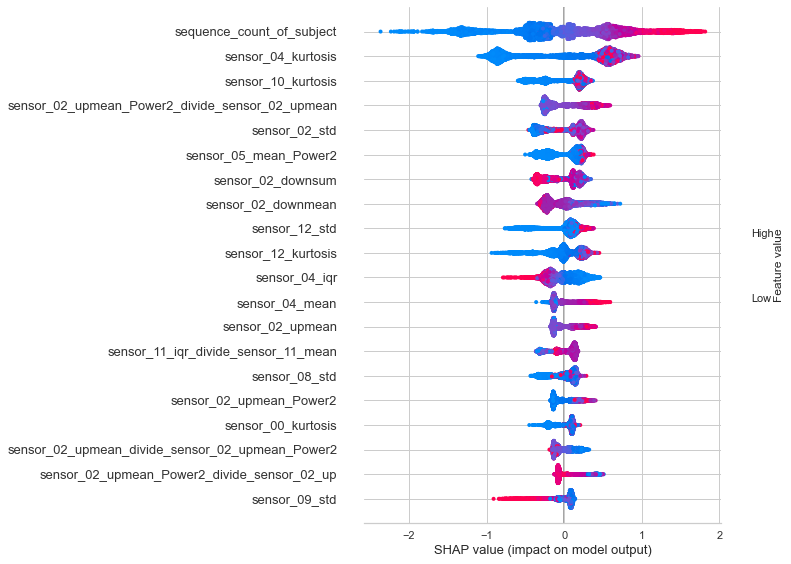

In [ ]:
best_Accuracy_model = automl(optimize = 'Accuracy')
interpret_model(best_Accuracy_model)

In [ ]:
final_model = finalize_model(best_Accuracy_model)  # ボールドアウトセットを含む、すべてのデータセットでトレーニングしなおす


In [ ]:
best_params = final_model.get_params()

In [ ]:
pred = predict_model(final_model, data=test_pivoted, raw_score=True)  # raw_score=その予測になる確率をScore二変種する

In [ ]:
pred.head()

,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_kurtosis,sensor_02_mean,sensor_02_std,...,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject,Label,Score_0,Score_1
subject,,,,,,,,,,,,,,,,,,,,,
684,-0.002602,1.091741,1.078632,6.400715,-0.036432,4.499484,0.990284,13.679216,0.883711,0.291290,...,0.666667,-1.332820,0.176667,-0.176667,0.166667,-0.166602,70,1,0.2596,0.7404
935,0.028516,1.450040,0.844281,6.634402,0.002276,0.775379,1.079832,0.125149,0.272902,0.184520,...,1.226502,-1.560349,0.559836,-0.228685,0.245300,-0.173372,59,1,0.0308,0.9692
924,0.057664,5.083618,6.590224,0.485832,-0.021796,2.903657,4.217700,-0.772405,-0.617986,0.116012,...,0.333333,-0.333333,0.295000,-0.261667,0.166667,-0.166667,38,0,0.9982,0.0018
769,-0.004791,0.914917,1.034583,0.951666,0.014863,0.950923,1.095063,0.485525,-0.580709,0.142112,...,0.405000,-0.071667,0.203333,-0.071667,0.135000,-0.071667,70,1,0.4471,0.5529
764,-0.001443,2.783685,0.857612,25.700057,-0.025350,23.942241,1.266544,24.650200,-0.164191,0.160825,...,0.570786,-0.903606,0.201356,-0.312851,0.114157,-0.150601,49,1,0.4562,0.5438


In [ ]:
sub.head()

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0


In [ ]:
pred['Label']

subject
684    1
935    1
924    0
769    1
764    1
      ..
980    1
915    1
872    0
835    0
773    0
Name: Label, Length: 12218, dtype: int32

In [ ]:
sub = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
sub

,sequence,state
0,25968,0
1,25969,0
2,25970,0
3,25971,0
4,25972,0
...,...,...
12213,38181,0
12214,38182,0
12215,38183,0
12216,38184,0


In [ ]:
sub['state'] = pred.reset_index()['Score_1']

In [ ]:
sub.to_csv('submission.csv', index=False)
sub

,sequence,state
0,25968,0.7404
1,25969,0.9692
2,25970,0.0018
3,25971,0.5529
4,25972,0.5438
...,...,...
12213,38181,0.8481
12214,38182,0.8826
12215,38183,0.2717
12216,38184,0.0069
